In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pyswarm import pso  # Import PSO library
import joblib
import random
import tensorflow as tf

In [1]:
!pip install pyswarm
!pip install openpyxl

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=4d98cf927b1a0631d2591549303a48011719fe228911223b94c913d55a4bf232
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Shape X_seq: (17282, 10, 3)
Shape y_seq: (17282, 3)
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6249 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 2/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4115 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 3/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3356 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 4/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3082 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 5/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2502 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 6/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2224 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 7/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2289 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 8/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1926 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 9/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2063 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 10/500

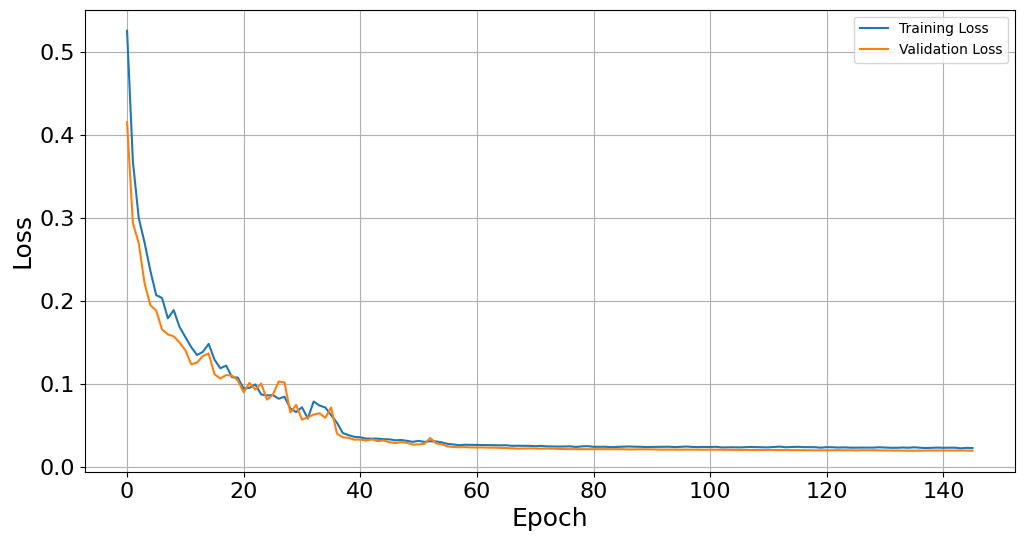

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MSE Fx: 0.15986516990164837, R² Fx: 0.9839249775802997
MSE Fy: 0.3645889626246089, R² Fy: 0.9841399987467252
MSE Fz: 2.7200844772166723, R² Fz: 0.9755422195810928


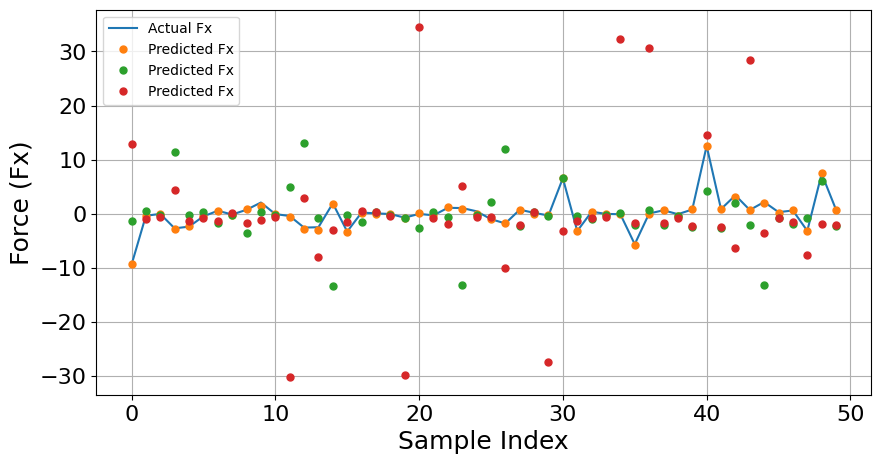

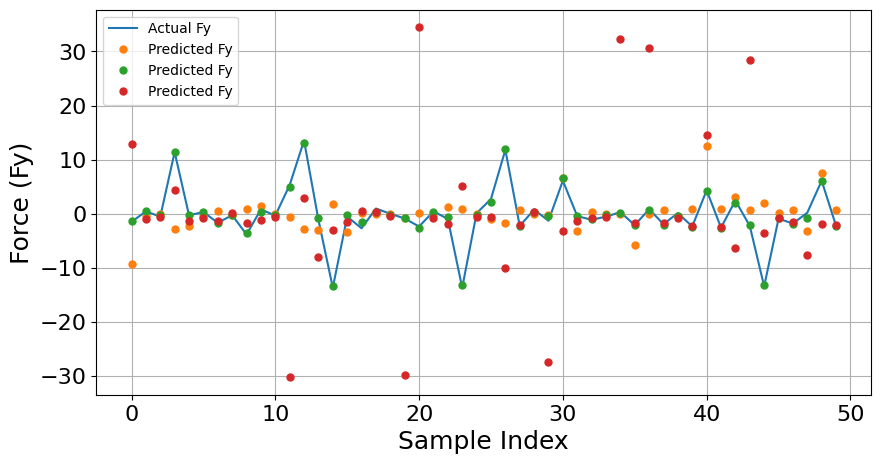

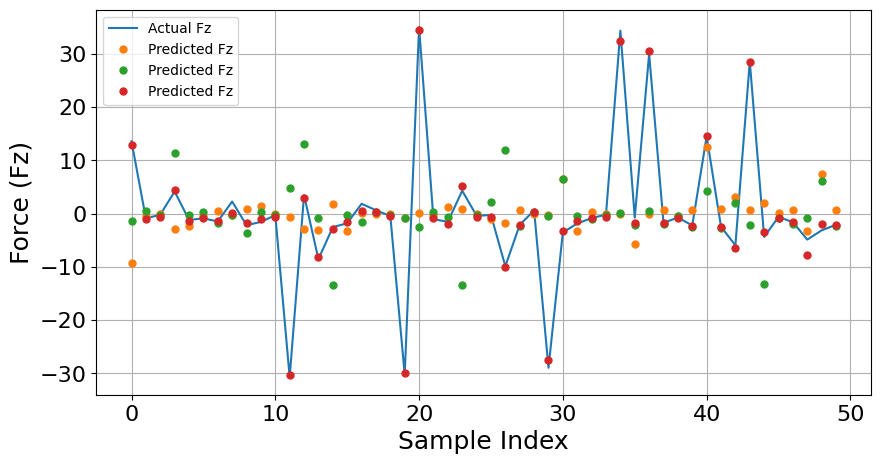

['val_features_lstm2.pkl']

In [6]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)  # Seed for NumPy
random.seed(seed_value)     # Seed for Python random
tf.random.set_seed(seed_value)  # Seed for TensorFlow

# 1. Load dataset
data = pd.read_excel('new.xlsx')  # Ganti dengan nama file Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X = data[['Magx', 'Magy', 'Magz']].values  # Mengambil kolom medan magnet
y = data[['Fx', 'Fy', 'Fz']].values  # Mengambil kolom gaya

# 2. Normalisasi data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 3. Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_seq, y_seq = [], []

for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i:i + time_steps])  # Membentuk urutan data input dengan 10 timestep
    y_seq.append(y_scaled[i + time_steps])  # Target output setelah 10 timestep

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Periksa dimensi data setelah membentuk sequence
print("Shape X_seq:", X_seq.shape)  # (samples, timestep, features)
print("Shape y_seq:", y_seq.shape)  # (samples, output_dim)

# 4. Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=seed_value)

# 5. Model LSTM
model = Sequential()

# Layer pertama LSTM dengan Dropout
model.add(LSTM(160, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Layer kedua LSTM dengan Dropout
model.add(LSTM(160, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))

# 6. Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# 7. Callbacks (Early Stopping dan Reduce LR on Plateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# 8. Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# 9. Plot hasil pelatihan (Training vs Validation Loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Loss History')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)  # Atur ukuran font pada tick sumbu x
plt.yticks(fontsize=16)  # Atur ukuran font pada tick sumbu y
plt.savefig('Loss History.png')  # Simpan gambar Fx
plt.show()

# 10. Evaluasi (Mean Squared Error dan R² Score untuk setiap sumbu)

# Prediksi data validasi
y_pred = model.predict(X_val)

# Inverse transform prediksi dan nilai aktual agar kembali ke skala asli
y_val_original = scaler_y.inverse_transform(y_val)
y_pred_original = scaler_y.inverse_transform(y_pred)

# MSE dan R² Score untuk setiap sumbu (Fx, Fy, Fz)
mse_fx = mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0])
mse_fy = mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1])
mse_fz = mean_squared_error(y_val_original[:, 2], y_pred_original[:, 2])

r2_fx = r2_score(y_val_original[:, 0], y_pred_original[:, 0])
r2_fy = r2_score(y_val_original[:, 1], y_pred_original[:, 1])
r2_fz = r2_score(y_val_original[:, 2], y_pred_original[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# 11. Plot perbandingan nilai aktual vs nilai prediksi untuk setiap sumbu
# Tentukan indeks untuk 250 data terakhir (misal, dari 2750 hingga 3000)

# Plot untuk Fx (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:50, 0], label='Actual Fx', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:50,], label='Predicted Fx', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fx: Actual vs Predicted (Last 250 Samples)', fontsize=14)  # Perbesar judul
plt.xlabel('Sample Index', fontsize=18)  # Perbesar label sumbu x
plt.ylabel('Force (Fx)', fontsize=18)  # Perbesar label sumbu y
plt.legend()
plt.grid()
plt.xticks(fontsize=16)  # Atur ukuran font pada tick sumbu x
plt.yticks(fontsize=16)  # Atur ukuran font pada tick sumbu y
plt.savefig('Fx_Comparison_Last_250.png')  # Simpan gambar Fx
plt.show()

# Plot untuk Fy (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:50, 1], label='Actual Fy', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:50,], label='Predicted Fy', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fy: Actual vs Predicted (Last 250 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Force (Fy)', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Fy_Comparison_Last_250.png')  # Simpan gambar Fy
plt.show()

# Plot untuk Fz (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:50, 2], label='Actual Fz', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:50,], label='Predicted Fz', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fz: Actual vs Predicted (Last 250 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Force (Fz)', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Fz_Comparison_Last_250.png')  # Simpan gambar Fz
plt.show()

# 13. Simpan model
model.save('lstm_model2.h5')
joblib.dump(scaler_X, 'scaler_X.pkl')  # Simpan scaler ke file
joblib.dump(scaler_y, 'scaler_y.pkl')
# Simpan fitur yang diekstraksi dari LSTM
joblib.dump(train_features, 'train_features_lstm2.pkl')
joblib.dump(val_features, 'val_features_lstm2.pkl')


MSE Fx (SVM): 0.01603724042975342, R² Fx (SVM): 0.9839519139452474
MSE Fy (SVM): 0.01520095770713454, R² Fy (SVM): 0.9848098300242012
MSE Fz (SVM): 0.02543089085491673, R² Fz (SVM): 0.9754343258213919


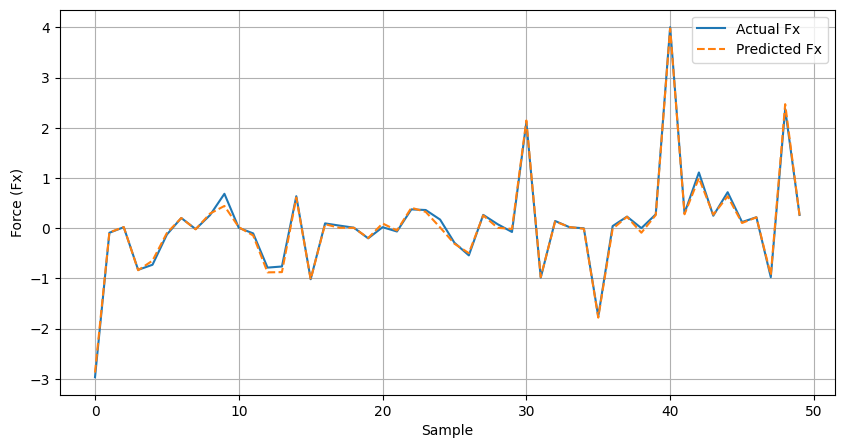

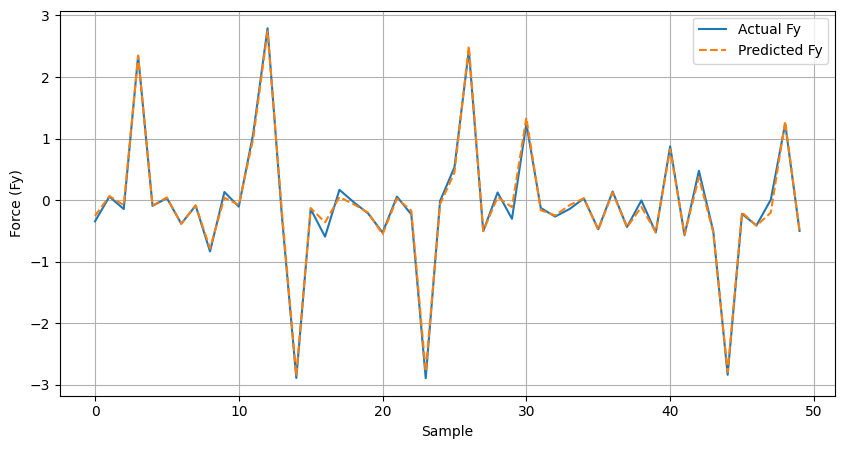

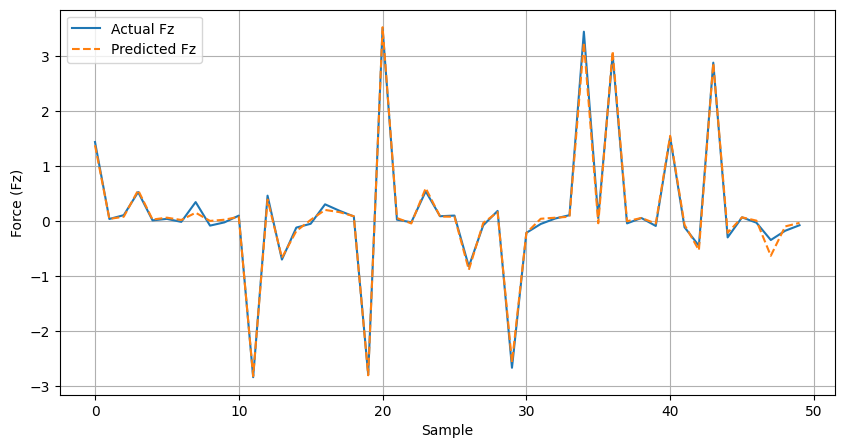

['scaler_y2.pkl']

In [14]:
# Memuat fitur LSTM dari file
train_features = joblib.load('train_features_lstm2.pkl')
val_features = joblib.load('val_features_lstm2.pkl')

# 13. Train SVM dengan parameter manual untuk semua sumbu
svm_fx = SVR()
svm_fy = SVR()
svm_fz = SVR()

# Train SVM untuk setiap gaya
svm_fx.fit(train_features, y_train[:, 0])  # Fx
svm_fy.fit(train_features, y_train[:, 1])  # Fy
svm_fz.fit(train_features, y_train[:, 2])  # Fz

# Prediksi dengan SVM
pred_fx = svm_fx.predict(val_features)
pred_fy = svm_fy.predict(val_features)
pred_fz = svm_fz.predict(val_features)

# Evaluasi model hybrid (LSTM + SVM)
mse_fx = mean_squared_error(y_val[:, 0], pred_fx)
mse_fy = mean_squared_error(y_val[:, 1], pred_fy)
mse_fz = mean_squared_error(y_val[:, 2], pred_fz)

r2_fx = r2_score(y_val[:, 0], pred_fx)
r2_fy = r2_score(y_val[:, 1], pred_fy)
r2_fz = r2_score(y_val[:, 2], pred_fz)

print(f'MSE Fx (SVM): {mse_fx}, R² Fx (SVM): {r2_fx}')
print(f'MSE Fy (SVM): {mse_fy}, R² Fy (SVM): {r2_fy}')
print(f'MSE Fz (SVM): {mse_fz}, R² Fz (SVM): {r2_fz}')

# 14. Plot perbandingan nilai aktual vs prediksi untuk Fx
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 0], label='Actual Fx')
plt.plot(pred_fx[:50], label='Predicted Fx', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.savefig('Fx_Comparison_250_SVM.png')
plt.show()

# Plot untuk Fy
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 1], label='Actual Fy')
plt.plot(pred_fy[:50], label='Predicted Fy', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.savefig('Fy_Comparison_250_SVM.png')
plt.show()

# Plot untuk Fz
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 2], label='Actual Fz')
plt.plot(pred_fz[:50], label='Predicted Fz', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.savefig('Fz_Comparison_250_SVM.png')
plt.show()

# Simpan model SVM dan scaler
model.save('lstm_model_svm.h5')
joblib.dump(svm_fx, 'svm_fx.pkl')
joblib.dump(svm_fy, 'svm_fy.pkl')
joblib.dump(svm_fz, 'svm_fz.pkl')
joblib.dump(scaler_X, 'scaler_X2.pkl')
joblib.dump(scaler_y, 'scaler_y2.pkl')

MSE Fx (SVM): 0.01601335347858622, R² Fx (SVM): 0.9839758170506223
MSE Fy (SVM): 0.013741260825296931, R² Fy (SVM): 0.9862684909964536
MSE Fz (SVM): 0.0242418767936194, R² Fz (SVM): 0.9765828869233308


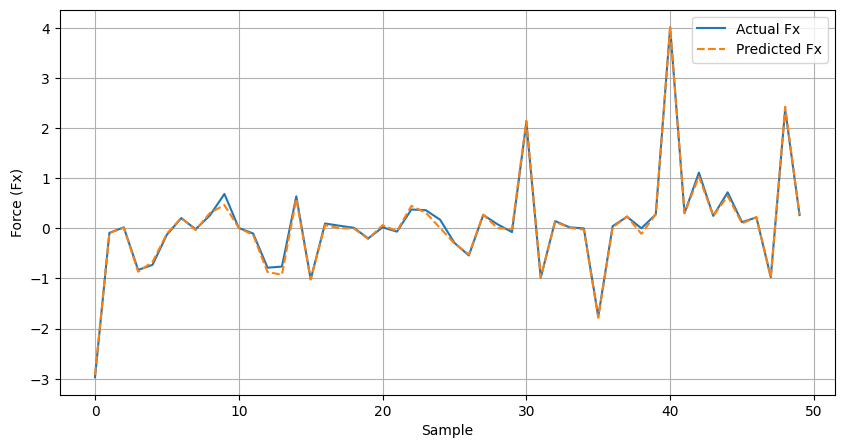

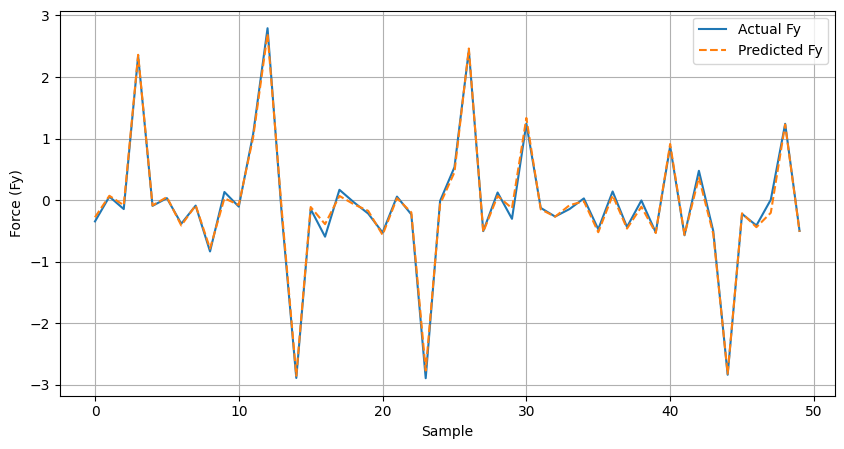

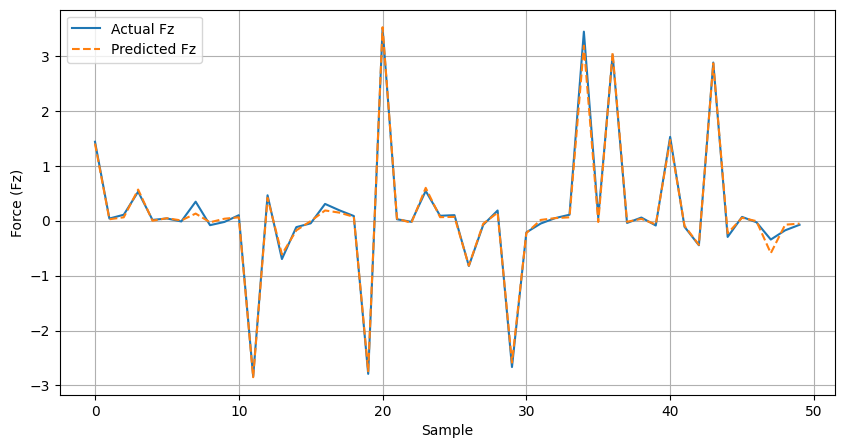

['scaler_y3.pkl']

In [15]:
# Memuat fitur LSTM dari file
train_features = joblib.load('train_features_lstm2.pkl')
val_features = joblib.load('val_features_lstm2.pkl')

# 10. Menentukan parameter SVM secara manual
# Atur parameter untuk masing-masing sumbu (Fx, Fy, Fz)
C_fx, epsilon_fx, gamma_fx = 48.8455464451738, 0.0599705772927854, 0.0113645168343877  # Masukkan nilai parameter manual untuk Fx
C_fy, epsilon_fy, gamma_fy = 98.0596223379808, 0.0904330174509664, 0.646700252625251 # Masukkan nilai parameter manual untuk Fy
C_fz, epsilon_fz, gamma_fz = 70.5220624139264, 0.0602303197685473, 0.459735544609855  # Masukkan nilai parameter manual untuk Fz

# 13. Train SVM dengan parameter manual untuk semua sumbu
svm_fx = SVR(C=C_fx, epsilon=epsilon_fx, gamma=gamma_fx)
svm_fy = SVR(C=C_fy, epsilon=epsilon_fy, gamma=gamma_fy)
svm_fz = SVR(C=C_fz, epsilon=epsilon_fz, gamma=gamma_fz)

# Train SVM untuk setiap gaya
svm_fx.fit(train_features, y_train[:, 0])  # Fx
svm_fy.fit(train_features, y_train[:, 1])  # Fy
svm_fz.fit(train_features, y_train[:, 2])  # Fz

# Prediksi dengan SVM
pred_fx = svm_fx.predict(val_features)
pred_fy = svm_fy.predict(val_features)
pred_fz = svm_fz.predict(val_features)

# Evaluasi model hybrid (LSTM + SVM)
mse_fx = mean_squared_error(y_val[:, 0], pred_fx)
mse_fy = mean_squared_error(y_val[:, 1], pred_fy)
mse_fz = mean_squared_error(y_val[:, 2], pred_fz)

r2_fx = r2_score(y_val[:, 0], pred_fx)
r2_fy = r2_score(y_val[:, 1], pred_fy)
r2_fz = r2_score(y_val[:, 2], pred_fz)

print(f'MSE Fx (SVM): {mse_fx}, R² Fx (SVM): {r2_fx}')
print(f'MSE Fy (SVM): {mse_fy}, R² Fy (SVM): {r2_fy}')
print(f'MSE Fz (SVM): {mse_fz}, R² Fz (SVM): {r2_fz}')

# 14. Plot perbandingan nilai aktual vs prediksi untuk Fx
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 0], label='Actual Fx')
plt.plot(pred_fx[:50], label='Predicted Fx', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.savefig('Fx_Comparison_250_SVM.png')
plt.show()

# Plot untuk Fy
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 1], label='Actual Fy')
plt.plot(pred_fy[:50], label='Predicted Fy', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.savefig('Fy_Comparison_250_SVM.png')
plt.show()

# Plot untuk Fz
plt.figure(figsize=(10, 5))
plt.plot(y_val[:50, 2], label='Actual Fz')
plt.plot(pred_fz[:50], label='Predicted Fz', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.savefig('Fz_Comparison_250_SVM.png')
plt.show()

# Simpan model SVM dan scaler
model.save('lstm_model_svm_opt.h5')
joblib.dump(svm_fx, 'svm_fx_optimized2.pkl')
joblib.dump(svm_fy, 'svm_fy_optimized2.pkl')
joblib.dump(svm_fz, 'svm_fz_optimized2.pkl')
joblib.dump(scaler_X, 'scaler_X3.pkl')
joblib.dump(scaler_y, 'scaler_y3.pkl')

In [16]:

from tensorflow.keras.models import load_model  # Tambahkan ini untuk mengimpor load_model

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# 1. Load dataset untuk pengujian
test_data = pd.read_excel('dataUji.xlsx')  # Ganti dengan nama file dataset uji Anda
X_test = test_data[['Magx', 'Magy', 'Magz']].values
y_test = test_data[['Fx', 'Fy', 'Fz']].values

# 2. Load scaler dan normalisasi data uji
scaler_X = joblib.load('scaler_X2.pkl')
scaler_y = joblib.load('scaler_y2.pkl')

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_test_seq, y_test_seq = [], []

for i in range(len(X_test_scaled) - time_steps):
    X_test_seq.append(X_test_scaled[i:i + time_steps])
    y_test_seq.append(y_test_scaled[i + time_steps])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# 3. Load model LSTM
lstm_model = load_model('lstm_model2.h5')  # Model LSTM dasar
lstm_model_svm = load_model('lstm_model_svm.h5')  # Model LSTM-SVM
lstm_model_svm_opt = load_model('lstm_model_svm_opt.h5')  # Model LSTM-SVM yang dioptimasi

# Ekstraksi fitur dari model LSTM
lstm_features = lstm_model2.predict(X_test_seq)
lstm_svm_features = lstm_model_svm.predict(X_test_seq)
lstm_svm_opt_features = lstm_model_svm_opt.predict(X_test_seq)

# 4. Load model SVM
svm_fx = joblib.load('svm_fx.pkl')
svm_fy = joblib.load('svm_fy.pkl')
svm_fz = joblib.load('svm_fz.pkl')

svm_fx_opt = joblib.load('svm_fx_optimized2.pkl')
svm_fy_opt = joblib.load('svm_fy_optimized2.pkl')
svm_fz_opt = joblib.load('svm_fz_optimized2.pkl')

# Prediksi LSTM
y_pred_lstm = scaler_y.inverse_transform(lstm_features)

# Prediksi LSTM-SVM
pred_fx_svm = svm_fx.predict(lstm_svm_features)
pred_fy_svm = svm_fy.predict(lstm_svm_features)
pred_fz_svm = svm_fz.predict(lstm_svm_features)
y_pred_lstm_svm = scaler_y.inverse_transform(np.stack([pred_fx_svm, pred_fy_svm, pred_fz_svm], axis=1))

# Prediksi LSTM-SVM yang dioptimasi
pred_fx_svm_opt = svm_fx_opt.predict(lstm_svm_opt_features)
pred_fy_svm_opt = svm_fy_opt.predict(lstm_svm_opt_features)
pred_fz_svm_opt = svm_fz_opt.predict(lstm_svm_opt_features)
y_pred_lstm_svm_opt = scaler_y.inverse_transform(np.stack([pred_fx_svm_opt, pred_fy_svm_opt, pred_fz_svm_opt], axis=1))

# Data aktual
y_test_original = scaler_y.inverse_transform(y_test_seq)

# 5. Visualisasi hasil
sumbu = ['Fx', 'Fy', 'Fz']
y_actual = y_test_original.T
y_preds = [y_pred_lstm.T, y_pred_lstm_svm.T, y_pred_lstm_svm_opt.T]
labels = ['LSTM', 'LSTM-SVM', 'LSTM-SVM Optimized']

plt.figure(figsize=(16, 12))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_actual[i], label=f'Actual {sumbu[i]}', linewidth=2)
    for y_pred, label in zip(y_preds, labels):
        plt.plot(y_pred[i], label=f'{label} {sumbu[i]}', linestyle='--')
    plt.title(f'Comparison of Actual and Predicted {sumbu[i]}')
    plt.xlabel('Sample')
    plt.ylabel(sumbu[i])
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


NameError: name 'lstm_model2' is not defined

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE Fx: 0.27723102448799497, R² Fx: 0.9726666318688115
MSE Fy: 0.3241622031863358, R² Fy: 0.9813768202448151
MSE Fz: 2.7130253013583436, R² Fz: 0.9722743027439456


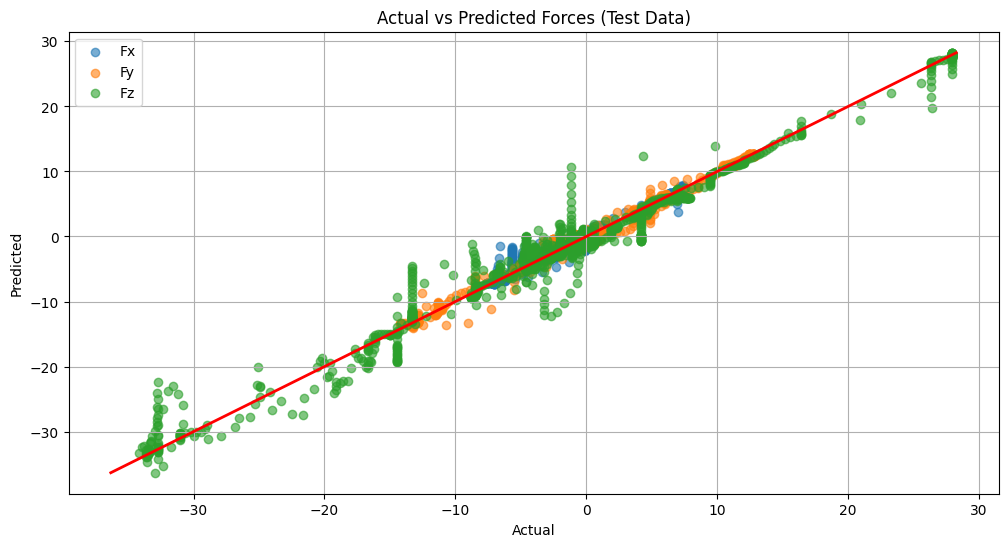

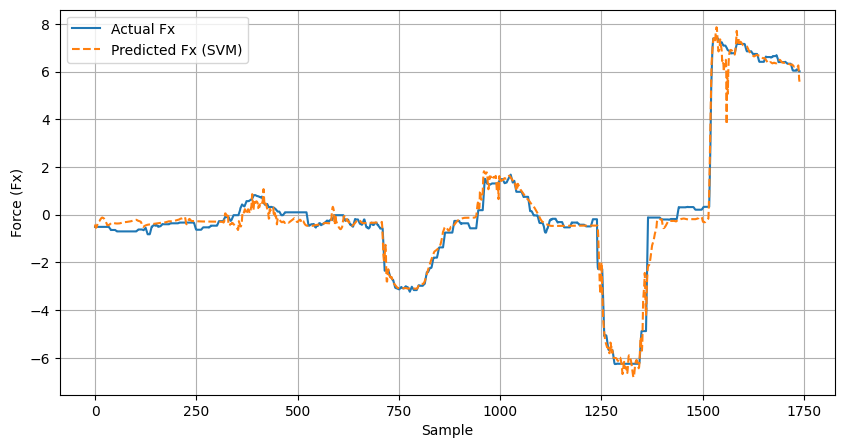

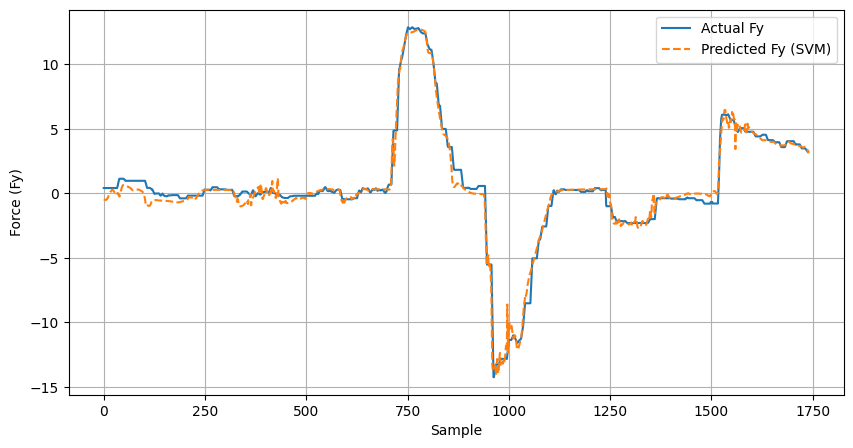

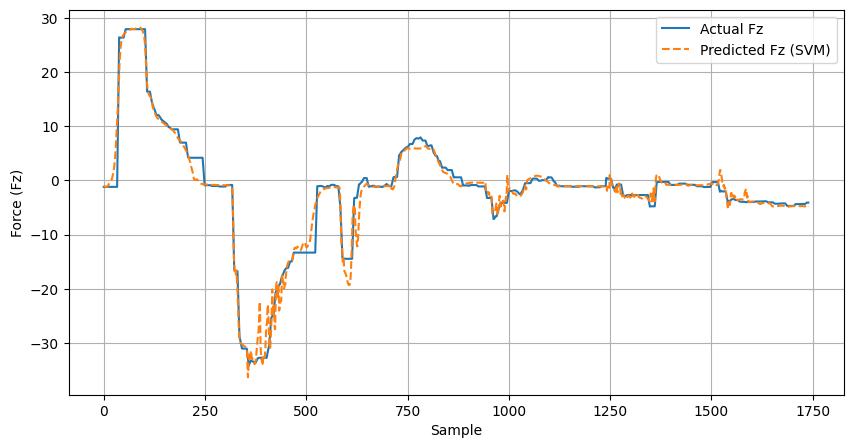

In [ ]:
from tensorflow.keras.models import load_model  # Tambahkan ini untuk mengimpor load_model

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# 1. Load dataset untuk pengujian
test_data = pd.read_excel('dataUji.xlsx')  # Ganti dengan nama file dataset uji Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X_test = test_data[['Magx', 'Magy', 'Magz']].values
y_test = test_data[['Fx', 'Fy', 'Fz']].values

# 2. Load scaler dan normalisasi data uji
scaler_X = joblib.load('scaler_X2.pkl')
scaler_y = joblib.load('scaler_y2.pkl')

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_test_seq, y_test_seq = [], []

for i in range(len(X_test_scaled) - time_steps):
    X_test_seq.append(X_test_scaled[i:i + time_steps])
    y_test_seq.append(y_test_scaled[i + time_steps])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# 3. Load model LSTM dan ekstrak fitur
lstm_model = load_model('lstm_model2.h5')

# Ekstraksi fitur dari model LSTM
test_features = lstm_model.predict(X_test_seq)

# 4. Load model SVM untuk setiap sumbu gaya
svm_fx = joblib.load('svm_fx_optimized2.pkl')
svm_fy = joblib.load('svm_fy_optimized2.pkl')
svm_fz = joblib.load('svm_fz_optimized2.pkl')

# Prediksi dengan model SVM
pred_fx_scaled = svm_fx.predict(test_features)
pred_fy_scaled = svm_fy.predict(test_features)
pred_fz_scaled = svm_fz.predict(test_features)

# 5. Inverse transform prediksi dan nilai aktual
y_pred_scaled = np.stack([pred_fx_scaled, pred_fy_scaled, pred_fz_scaled], axis=1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_seq)

# 6. Evaluasi model
mse_fx = mean_squared_error(y_test_original[:, 0], y_pred[:, 0])
mse_fy = mean_squared_error(y_test_original[:, 1], y_pred[:, 1])
mse_fz = mean_squared_error(y_test_original[:, 2], y_pred[:, 2])

r2_fx = r2_score(y_test_original[:, 0], y_pred[:, 0])
r2_fy = r2_score(y_test_original[:, 1], y_pred[:, 1])
r2_fz = r2_score(y_test_original[:, 2], y_pred[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# 7. Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original[:, 0], y_pred[:, 0], label='Fx', alpha=0.6)
plt.scatter(y_test_original[:, 1], y_pred[:, 1], label='Fy', alpha=0.6)
plt.scatter(y_test_original[:, 2], y_pred[:, 2], label='Fz', alpha=0.6)
plt.plot([min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         color='red', linewidth=2)
plt.title('Actual vs Predicted Forces (Test Data)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()
plt.show()

# Visualisasi untuk setiap sumbu
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 0], label='Actual Fx')
plt.plot(y_pred[250:2000, 0], label='Predicted Fx (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 1], label='Actual Fy')
plt.plot(y_pred[250:2000, 1], label='Predicted Fy (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 2], label='Actual Fz')
plt.plot(y_pred[250:2000, 2], label='Predicted Fz (SVM)', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.show()


244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Prediksi dalam skala asli:
Prediksi Fx: [-0.34262739 -0.34264527 -0.34247875 ... -0.45545076 -0.455464
 -0.4554451 ]
Prediksi Fy: [0.35775424 0.35800038 0.35830504 ... 0.32582049 0.32622407 0.3265759 ]
Prediksi Fz: [-0.52047032 -0.52012707 -0.51961348 ... -1.1109052  -1.11144692
 -1.11201812]
Evaluasi untuk Fx - MSE: 0.14335939053147037, R²: 0.9835101011665122
Evaluasi untuk Fy - MSE: 0.37502290714315817, R²: 0.9845191168910294
Evaluasi untuk Fz - MSE: 1.6554834792192987, R²: 0.9813454043617597


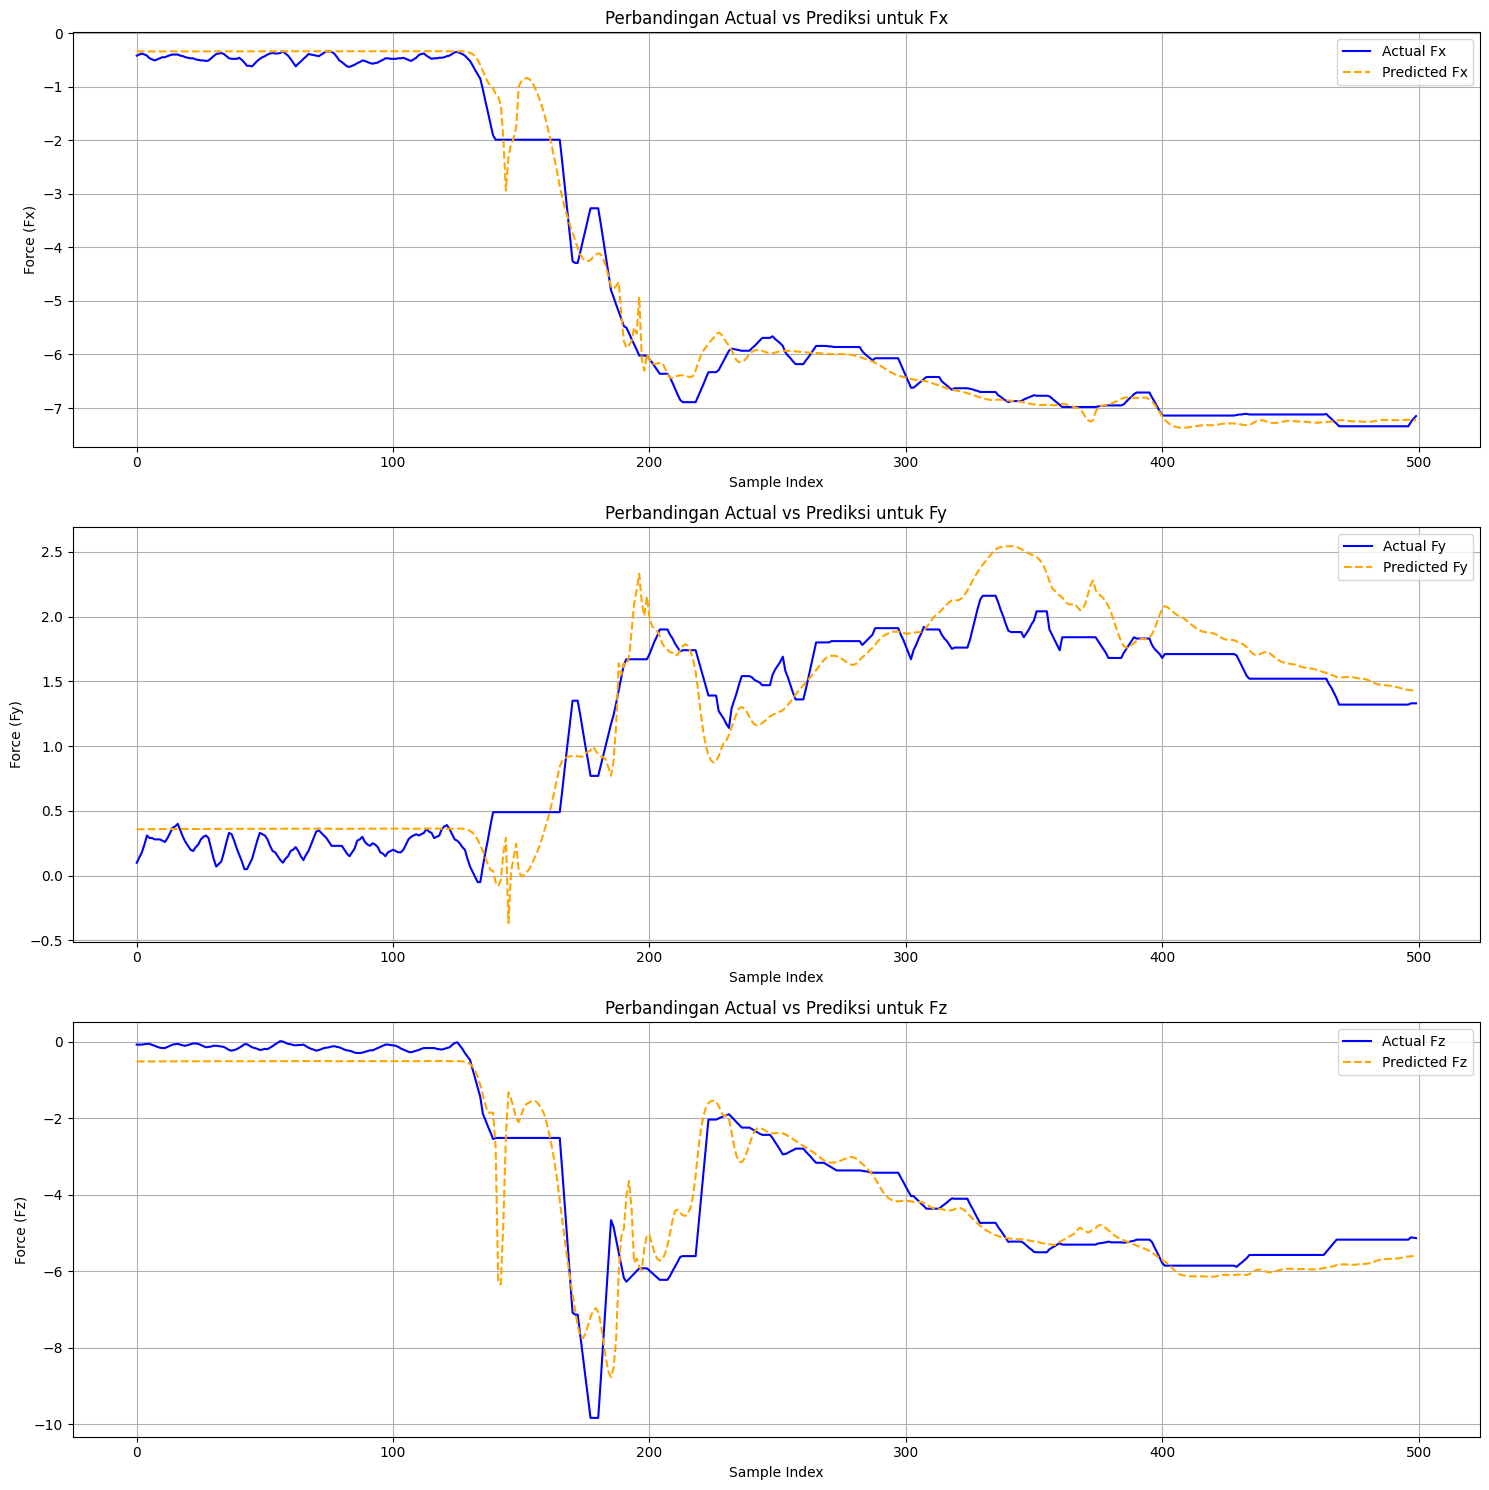

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import load_model

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)  # Seed for NumPy
import random
random.seed(seed_value)     # Seed for Python random
import tensorflow as tf
tf.random.set_seed(seed_value)  # Seed for TensorFlow

# 1. Load new dataset
data = pd.read_excel('datasetKamis.xlsx')  # Ganti dengan nama file Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X_new = data[['Magx', 'Magy', 'Magz']].values  # Mengambil kolom medan magnet
y_true = data[['Fx', 'Fy', 'Fz']].values  # Mengambil kolom gaya

# 2. Normalisasi data
scaler_X = joblib.load('scaler_X2.pkl')  # Memuat scaler yang telah disimpan
scaler_y = joblib.load('scaler_y2.pkl')  # Memuat scaler yang telah disimpan

X_new_scaled = scaler_X.transform(X_new)

# 3. Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_seq_new = []

for i in range(len(X_new_scaled) - time_steps):
    X_seq_new.append(X_new_scaled[i:i + time_steps])  # Membentuk urutan data input dengan 10 timestep

X_seq_new = np.array(X_seq_new)

# 4. Memuat model LSTM
model_lstm = load_model('lstm_model2.h5')

# 5. Ekstraksi fitur dari LSTM untuk data baru
features_new = model_lstm.predict(X_seq_new)

# 6. Memuat model SVM yang telah dilatih
svm_fx = joblib.load('svm_fx_optimized2.pkl')
svm_fy = joblib.load('svm_fy_optimized2.pkl')
svm_fz = joblib.load('svm_fz_optimized2.pkl')

# 7. Menggunakan model SVM untuk prediksi
pred_fx = svm_fx.predict(features_new)
pred_fy = svm_fy.predict(features_new)
pred_fz = svm_fz.predict(features_new)

# 8. Mengembalikan skala hasil prediksi ke skala asli
preds = np.column_stack((pred_fx, pred_fy, pred_fz))  # Menggabungkan prediksi menjadi satu array 2D
preds_inverse = scaler_y.inverse_transform(preds)  # Mengembalikan skala ke skala asli

# Menampilkan hasil
print("Prediksi dalam skala asli:")
print("Prediksi Fx:", preds_inverse[:, 0])
print("Prediksi Fy:", preds_inverse[:, 1])
print("Prediksi Fz:", preds_inverse[:, 2])

# 9. Evaluasi model
# Menghitung MSE dan R² untuk setiap sumbu
# Sesuaikan ukuran y_true dengan jumlah prediksi yang dihasilkan
y_true_adjusted = y_true[time_steps:]  # Menghilangkan beberapa baris awal sesuai dengan jumlah time steps

mse_fx = mean_squared_error(y_true_adjusted[:, 0], preds_inverse[:, 0])
r2_fx = r2_score(y_true_adjusted[:, 0], preds_inverse[:, 0])
print(f'Evaluasi untuk Fx - MSE: {mse_fx}, R²: {r2_fx}')

mse_fy = mean_squared_error(y_true_adjusted[:, 1], preds_inverse[:, 1])
r2_fy = r2_score(y_true_adjusted[:, 1], preds_inverse[:, 1])
print(f'Evaluasi untuk Fy - MSE: {mse_fy}, R²: {r2_fy}')

mse_fz = mean_squared_error(y_true_adjusted[:, 2], preds_inverse[:, 2])
r2_fz = r2_score(y_true_adjusted[:, 2], preds_inverse[:, 2])
print(f'Evaluasi untuk Fz - MSE: {mse_fz}, R²: {r2_fz}')

# 10. Visualisasikan hasil perbandingan aktual dan prediksi
samples_to_plot = 500  # Jumlah sampel yang ingin ditampilkan
plt.figure(figsize=(15, 15))

# Plot untuk Fx
plt.subplot(3, 1, 1)
plt.plot(y_true_adjusted[:samples_to_plot, 0], label='Actual Fx', color='blue')
plt.plot(preds_inverse[:samples_to_plot, 0], label='Predicted Fx', color='orange', linestyle='--')
plt.title('Perbandingan Actual vs Prediksi untuk Fx')
plt.xlabel('Sample Index')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()

# Plot untuk Fy
plt.subplot(3, 1, 2)
plt.plot(y_true_adjusted[:samples_to_plot, 1], label='Actual Fy', color='blue')
plt.plot(preds_inverse[:samples_to_plot, 1], label='Predicted Fy', color='orange', linestyle='--')
plt.title('Perbandingan Actual vs Prediksi untuk Fy')
plt.xlabel('Sample Index')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()

# Plot untuk Fz
plt.subplot(3, 1, 3)
plt.plot(y_true_adjusted[:samples_to_plot, 2], label='Actual Fz', color='blue')
plt.plot(preds_inverse[:samples_to_plot, 2], label='Predicted Fz', color='orange', linestyle='--')
plt.title('Perbandingan Actual vs Prediksi untuk Fz')
plt.xlabel('Sample Index')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig('Comparison_Actual_vs_Predicted.png')
plt.show()


In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=a2bf26987c6450ca40e1a2cbbf54954b6b1e5d44db8e68e802b9b0d7c3ee52c7
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
!pip install openpyxl